In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data.csv')
df.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,1045,1.759105,1.424226,2.213346,2.786321
1,1,450,1532,1.735650,1.372342,2.162660,2.693265
2,2,450,1567,1.737972,1.364822,2.150216,2.660373
3,3,450,1527,1.710710,1.380921,2.096891,2.534916
4,4,450,1532,1.733850,1.385576,2.138852,2.635823


In [3]:
# for testing of data before the accident 
traindf_before =  df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead']].copy()
traindf_before =  traindf_before.iloc[:144, :]
traindf_before =  traindf_before.to_numpy()
traindf_before_list = np.split(traindf_before, 18)

data_to_plot_before = df.iloc[:144, :]
data_to_plot_before = data_to_plot_before.to_numpy()
data_to_plot_before_list = np.split(data_to_plot_before, 18)

# for plotting of data with accident (there is too many points for visible results otherwise)
data_to_plot = df.iloc[::6, :]
data_to_plot = data_to_plot.to_numpy()

In [4]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) > 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = model
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        plt.plot(silhouette_range[:], silhouette_scores[:])
        plt.xlabel('Number Of Clusers')
        plt.ylabel('Silhouette Score')
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
        plt.show()
        plt.close() 
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
                return int(i[0])
    else:
        print('couldnt get the scores, plz help')
        print('returning number of clusters = ' + str(n_clusters_min))
        return n_clusters_min

In [5]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 12)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [6]:
data_split_modified_z_12.shape

(141, 6)

In [7]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 3)

Threshold tested 0,2, 0.1, 0,05

0.05 is the only one able to pick on up the differences

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


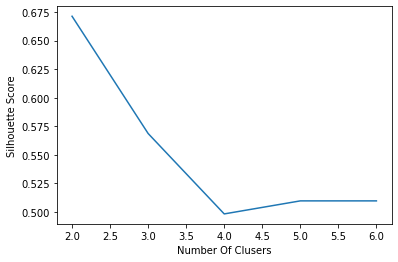

The highest silhouette scores(0.671251049556711) is for 2 clusers


In [8]:
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :2])

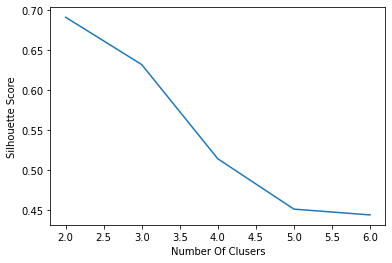

The highest silhouette scores(0.6913240738543084) is for 2 clusers


In [9]:
model_before = Birch(n_clusters=None, threshold=0.05)

for i in traindf_before_list:
    model_before.partial_fit(i)

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_before, data_to_plot_before[:, 3:], 2, 6)

model_before.set_params(n_clusters = n)
model_before.partial_fit()
    
labels_before = model_before.predict(data_to_plot_before[:, 3:])

Text(0.5, 0.98, 'Test of clustering with and without outliers')

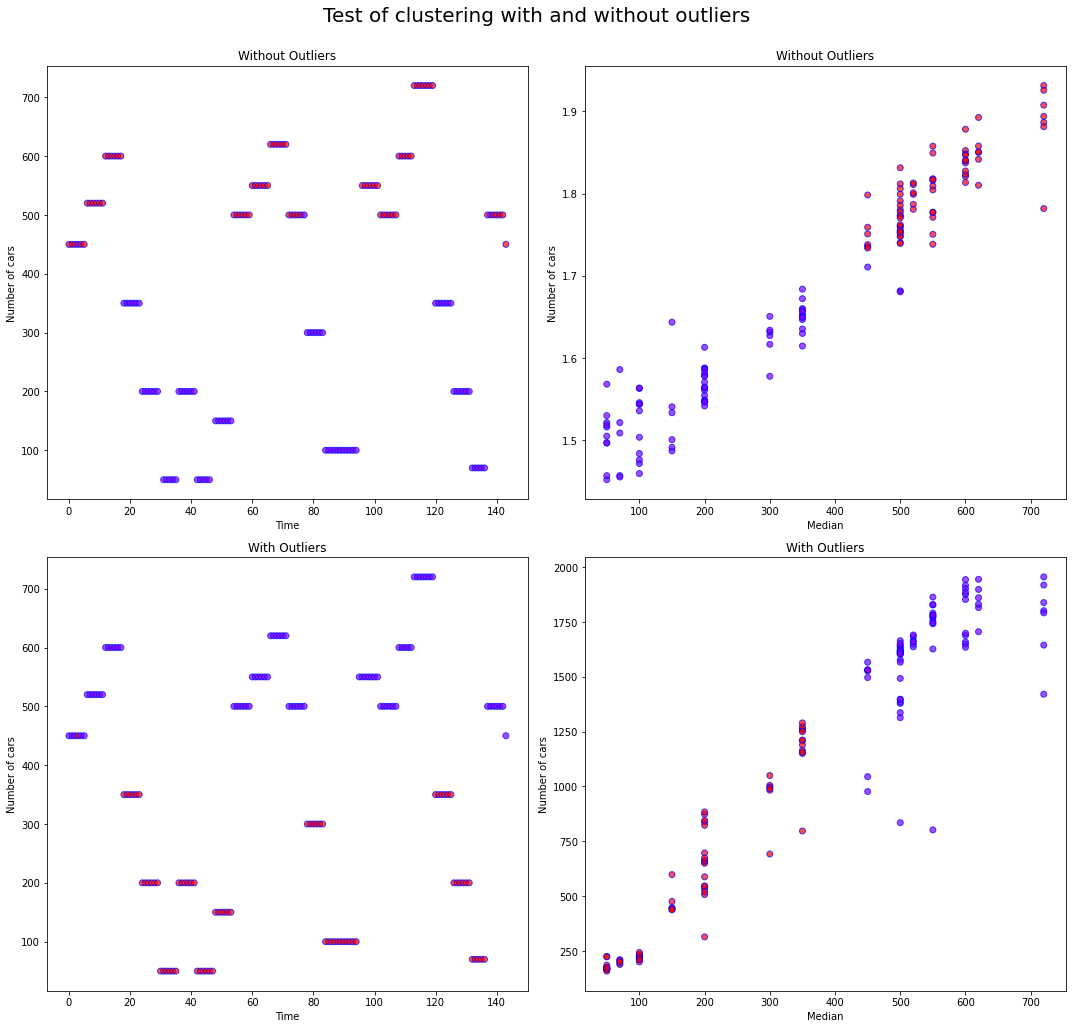

In [10]:
figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))

axs[0,0].scatter(data_split_modified_z_12[:,-1], data_split_modified_z_12[:,-2], c=labels_005, cmap='rainbow', alpha=0.7, edgecolors='b')
# axs[0,0].axvline(x=143, color='r')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Without Outliers")

axs[0,1].scatter(data_split_modified_z_12[:,-2], data_split_modified_z_12[:,0], c=labels_005, cmap='rainbow', alpha=0.7, edgecolors='b')    
# axs[0,1].axvline(x=143, color='r')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Median')
axs[0,1].title.set_text("Without Outliers")

axs[1,0].scatter(data_to_plot_before[:,0], data_to_plot_before[:,1], c=labels_before, cmap='rainbow', alpha=0.7, edgecolors='b')   
# axs[1,0].axvline(x=143, color='r')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("With Outliers")

axs[1,1].scatter(data_to_plot_before[:,1], data_to_plot_before[:,2], c=labels_before, cmap='rainbow', alpha=0.7, edgecolors='b')
# axs[1,1].axvline(x=143, color='r')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Median')
axs[1,1].title.set_text("With Outliers")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Test of clustering with and without outliers', fontsize=20)

Text(0.5, 0.98, 'Test of clustering with and without outliers')

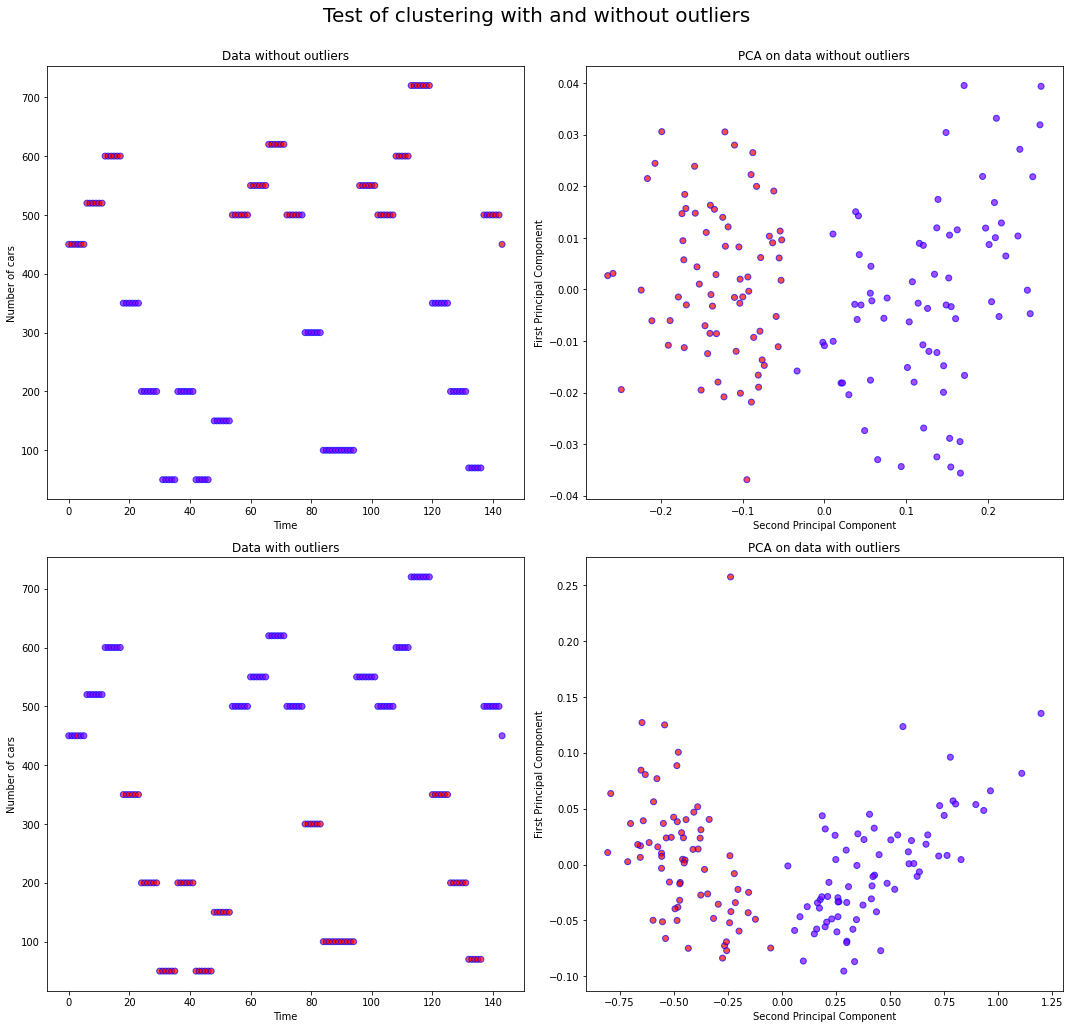

In [11]:
pca = PCA(n_components=2)
pc_before = pca.fit_transform(data_to_plot_before[:, 3:])
pc_outliers = pca.fit_transform(data_split_modified_z_12[:, :2])

figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))

axs[0,0].scatter(data_split_modified_z_12[:,-1], data_split_modified_z_12[:,-2], c=labels_005, cmap='rainbow', alpha=0.7, edgecolors='b')
# axs[0,0].axvline(x=143, color='r')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Data without outliers")

axs[0,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005, cmap='rainbow', alpha=0.7, edgecolors='b')    
# axs[0,1].axvline(x=143, color='r')
axs[0,1].set_ylabel('First Principal Component')
axs[0,1].set_xlabel('Second Principal Component')
axs[0,1].title.set_text("PCA on data without outliers")

axs[1,0].scatter(data_to_plot_before[:,0], data_to_plot_before[:,1], c=labels_before, cmap='rainbow', alpha=0.7, edgecolors='b')   
# axs[1,0].axvline(x=143, color='r')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Data with outliers")

axs[1,1].scatter(pc_before[:,0], pc_before[:,1], c=labels_before, cmap='rainbow', alpha=0.7, edgecolors='b')
# axs[1,1].axvline(x=143, color='r')
axs[1,1].set_ylabel('First Principal Component')
axs[1,1].set_xlabel('Second Principal Component')
axs[1,1].title.set_text("PCA on data with outliers")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Test of clustering with and without outliers', fontsize=20)


# WHOLE DATASET

In [12]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 12)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [13]:
data_split_modified_z_12.shape

(275, 6)

In [14]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 5)

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


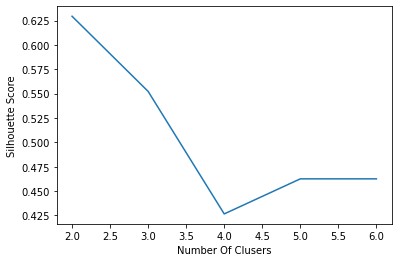

The highest silhouette scores(0.6294054139751448) is for 2 clusers


In [15]:
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :2])

In [16]:
df1 = df.to_numpy()
df_list = np.split(df1, 18)  

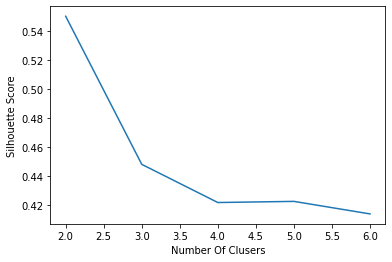

The highest silhouette scores(0.5502295427309387) is for 2 clusers


In [17]:
model = Birch(n_clusters=None, threshold=0.05)

for i in df_list:
    model.partial_fit(i[:, 3:])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model, df1[:, 3:], 2, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels_part = model.predict(data_to_plot[:, 3:])
labels_all = model.predict(df1[:, 3:])

Text(0.5, 0.98, 'Test of clustering with and without outliers')

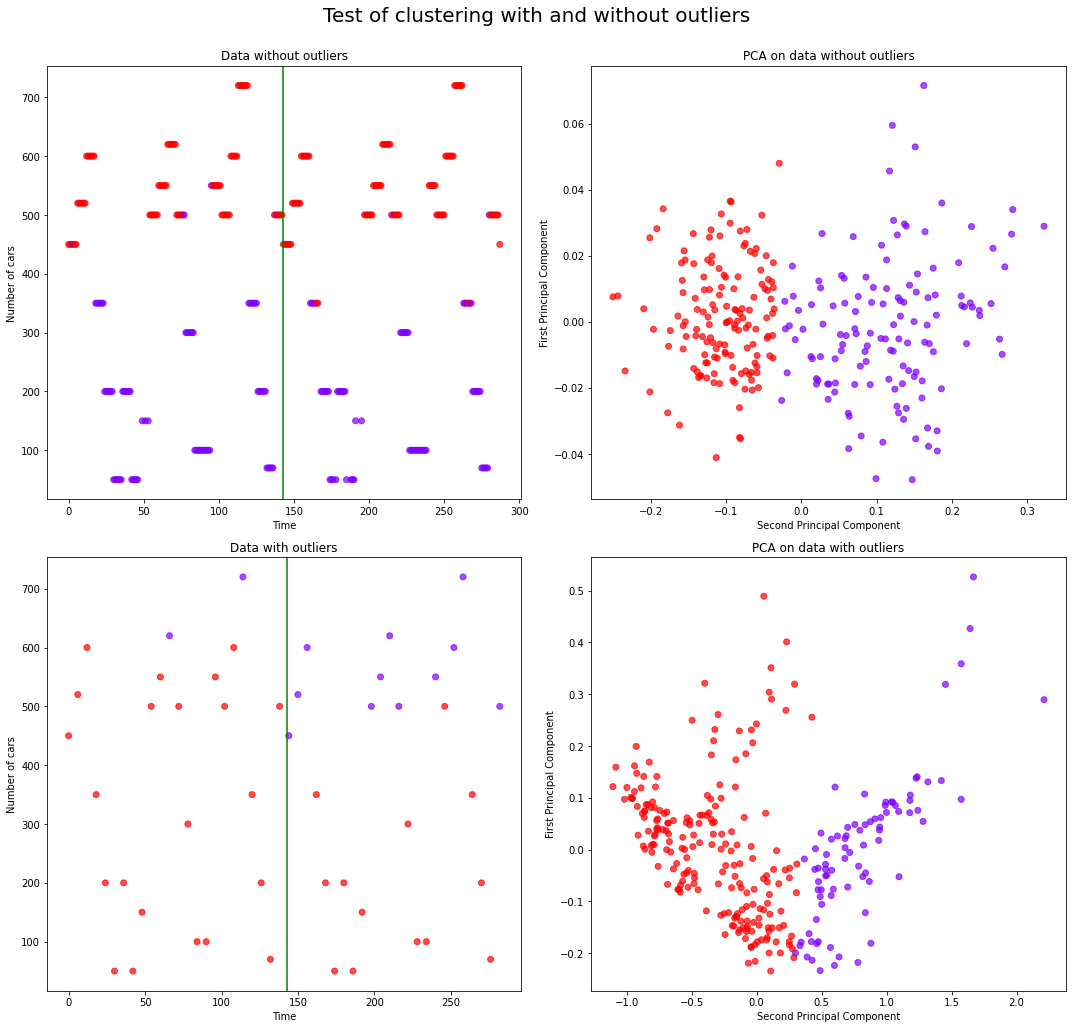

In [21]:
pca = PCA(n_components=2)
pc_before = pca.fit_transform(df1[:, 3:])
pc_outliers = pca.fit_transform(data_split_modified_z_12[:, :2])

figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))

axs[0,0].scatter(data_split_modified_z_12[:,-1], data_split_modified_z_12[:,-2], c=labels_005, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Data without outliers")

axs[0,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[0,1].set_ylabel('First Principal Component')
axs[0,1].set_xlabel('Second Principal Component')
axs[0,1].title.set_text("PCA on data without outliers")

axs[1,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_part, cmap='rainbow', alpha=0.7)   
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Data with outliers")

axs[1,1].scatter(pc_before[:,0], pc_before[:,1], c=labels_all, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[1,1].set_ylabel('First Principal Component')
axs[1,1].set_xlabel('Second Principal Component')
axs[1,1].title.set_text("PCA on data with outliers")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Test of clustering with and without outliers', fontsize=20)

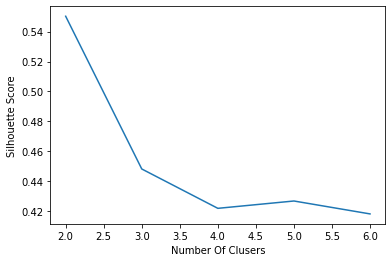

The highest silhouette scores(0.5502295427309387) is for 2 clusers


In [19]:
model_branching = Birch(n_clusters=None, threshold=0.05, branching_factor= 80)

for i in df_list:
    model_branching.partial_fit(i[:, 3:])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_branching, df1[:, 3:], 2, 6)

model_branching.set_params(n_clusters = n)
model_branching.partial_fit()
    
labels_part = model_branching.predict(data_to_plot[:, 3:])
labels_all = model_branching.predict(df1[:, 3:])

Text(0.5, 0.98, 'Test of clustering with and without outliers')

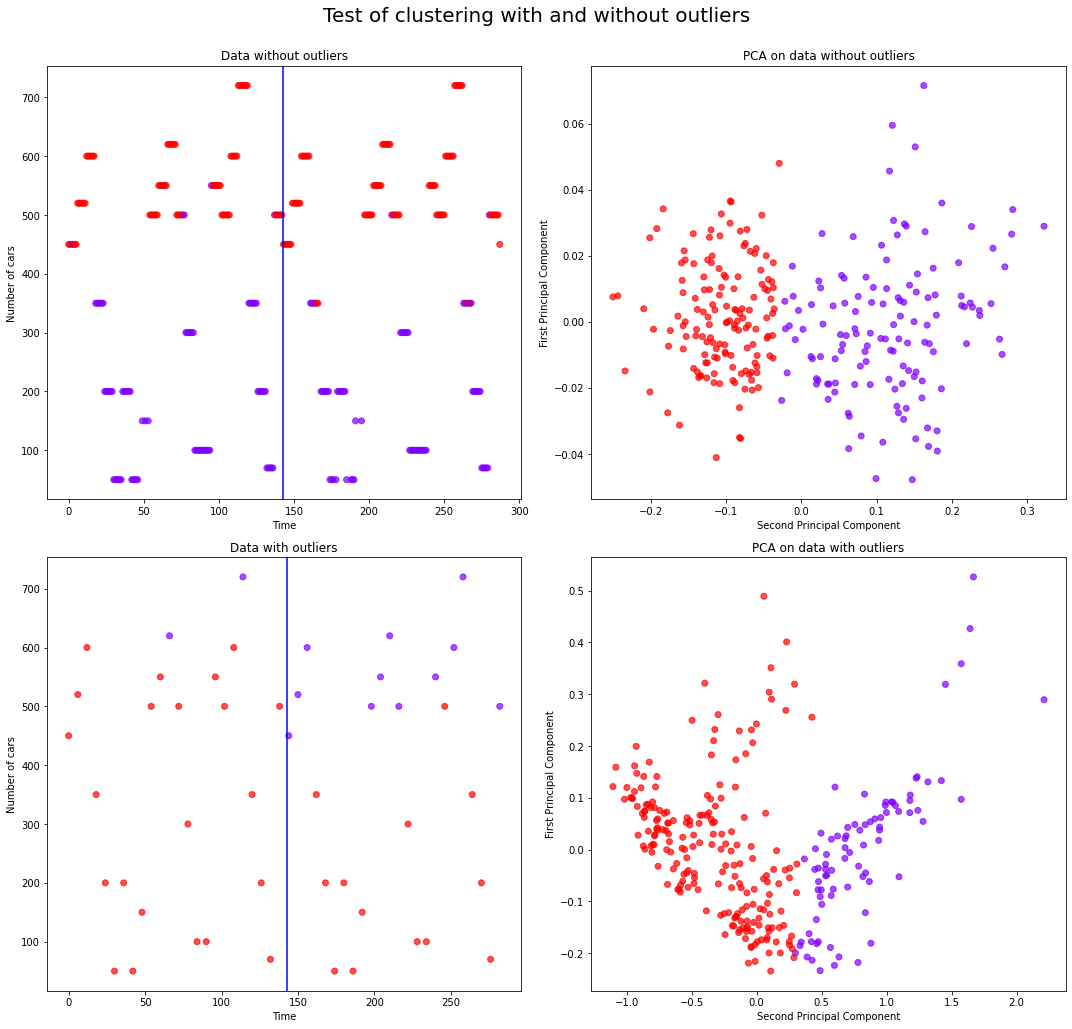

In [22]:
pca = PCA(n_components=2)
pc_before = pca.fit_transform(df1[:, 3:])
pc_outliers = pca.fit_transform(data_split_modified_z_12[:, :2])

figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))

axs[0,0].scatter(data_split_modified_z_12[:,-1], data_split_modified_z_12[:,-2], c=labels_005, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='b')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Data without outliers")

axs[0,1].scatter(pc_outliers[:,0], pc_outliers[:,1], c=labels_005, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[0,1].set_ylabel('First Principal Component')
axs[0,1].set_xlabel('Second Principal Component')
axs[0,1].title.set_text("PCA on data without outliers")

axs[1,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_part, cmap='rainbow', alpha=0.7)   
axs[1,0].axvline(x=143, color='b')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Data with outliers")

axs[1,1].scatter(pc_before[:,0], pc_before[:,1], c=labels_all, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[1,1].set_ylabel('First Principal Component')
axs[1,1].set_xlabel('Second Principal Component')
axs[1,1].title.set_text("PCA on data with outliers")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Test of clustering with and without outliers', fontsize=20)